In [ ]:
#!/usr/bin/python
# find . -name '.DS_Store' -type f -delete
# Chulwoo Pack

import sys
import os
from page import Page

SHOW_STEPS = True    # change this to false if you just want to see the final output for each page.
SAVE_OUTPUT = True
SAVE_DOCSTRUM = True

inputFolder = os.path.join('images')
outputFolder = os.path.join('output')

    
inputPath = os.path.join(inputFolder, os.listdir(inputFolder)[0])
outputPath = os.path.join(outputFolder, os.listdir(inputFolder)[0])

page = Page(inputPath, SHOW_STEPS, SAVE_DOCSTRUM)
#page = Page(inputPath, SHOW_STEPS)
    
if SAVE_OUTPUT:
    page.save(outputPath)  # save a copy of what is displayed. Used for getting images for the paper.
    
page.show((800, 800))

0.00	0.00	images/AC_global_skewed.jpg
Total  7587  characters are found.
1.28	1.28	got characters
5.68	4.40	got words & tuples
Total  2191  words are found.


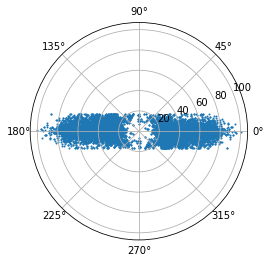

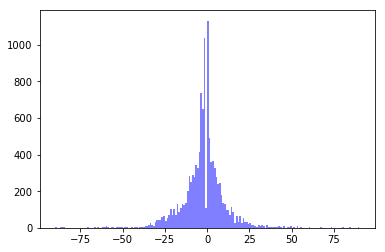

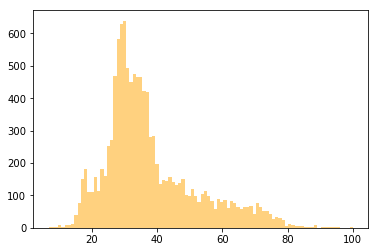

7.02	1.34	built Docstrum
7.02	0.00	finished analysing page
average time: 7.02

2191
2191


In [2]:
# LINE EXTRACTION TESTING

import sys
import os
from page import Page

import cv2
import math
import numpy
import subprocess
import os

import colors
import geometry as g
from box import Box
import text
from dimension import Dimension
from stopwatch import Stopwatch
import numpy
import matplotlib.pyplot as plt
import ntpath


SHOW_STEPS = True    # change this to false if you just want to see the final output for each page.
SAVE_OUTPUT = True
SAVE_DOCSTRUM = False

inputFolder = os.path.join('images')
outputFolder = os.path.join('output')

    
inputPath = os.path.join(inputFolder, os.listdir(inputFolder)[0])
outputPath = os.path.join(outputFolder, os.listdir(inputFolder)[0])

page = Page(inputPath, SHOW_STEPS, SAVE_DOCSTRUM)


if True:
    page.save(outputPath)  # save a copy of what is displayed. Used for getting images for the paper.
    
page.show((800, 800))

In [13]:
my_lines  = page.lines
for my_line in my_lines:
    my_line.group = None
    #print(my_line.group)

In [ ]:
my_lines_in_group

In [ ]:
my_lines_no_group

In [14]:
#NER VERSION: ADJUSTIVE SEARCHING ORDER

EPS = 3#1e-3
group_idx = 0
threshold_angle = 1.0
threshold_perpendist = 1.3 * 40.0
threshold_overlap    = 1.0
threshold_paralldist = 1.5 * 32.0

#SHOW_DETAIL = True
SHOW_DETAIL = False

########
# INIT #
########
# Get lines
my_lines  = page.lines
# Sorting lines
my_lines.sort(key=lambda line:((line.start.y+line.end.y)/2,(line.start.x+line.end.x)/2))
# Lines assigned a group
my_lines_in_group = []
# Lines not assigned any group yet
my_lines_no_group = []
for i in range(0,len(my_lines)-1):
    my_lines_no_group.append(i)
# First line, not dot (its index, i)
#first_line_idx = 0
delta_x_i = 0
delta_y_i = 0
for i in range(len(my_lines)):
    x_O_i = my_lines[i].start.x
    y_O_i = page.image.shape[0] - my_lines[i].start.y
    x_F_i = my_lines[i].end.x
    y_F_i = page.image.shape[0] - my_lines[i].end.y 
    delta_x_i = abs(x_F_i - x_O_i)
    delta_y_i = abs(y_F_i - y_O_i)
    if (delta_x_i != 0 and delta_y_i != 0): # Found!
        first_line_idx = i
        break
    else:
        my_lines_no_group.remove(i)

# Update queues
my_lines[first_line_idx].group = group_idx + 1     # first_line.group = 1
group_idx = group_idx + 1                          # group_idx = 1
my_lines_no_group.remove(first_line_idx)           # update my_lines_no_group
my_lines_in_group.append(first_line_idx)           # update my_lines_in_group
 
while(True): # Make sure looked up every lines
    #flag_found_none = True
    if ((len(my_lines_in_group) == 0) and (len(my_lines_no_group) == 0)):
        break
    #######################
    # Set the ith element #
    #######################
    i = 0
    ## TODO: Since, currently there is no lines in my_lines_in_group queue and lines are remained, find another line as ith element in my_lines_no_group queue with excluding dots. 
    if(len(my_lines_in_group) == 0):
        delta_x_i = 0
        delta_y_i = 0
        for candidate_line_idx in my_lines_no_group:
            x_O_i = my_lines[candidate_line_idx].start.x
            y_O_i = page.image.shape[0] - my_lines[candidate_line_idx].start.y
            x_F_i = my_lines[candidate_line_idx].end.x
            y_F_i = page.image.shape[0] - my_lines[candidate_line_idx].end.y 
            delta_x_i = abs(x_F_i - x_O_i)
            delta_y_i = abs(y_F_i - y_O_i)
            if (delta_x_i != 0 and delta_y_i != 0): # Found!
                i = candidate_line_idx
                my_lines_no_group.remove(candidate_line_idx)
                break
    else:
        i = my_lines_in_group.pop(0)
    # TODO: more sophisticated way to break?
    if (i == 0):
        break
    # No more lines to search
    if (len(my_lines_no_group) == 0):
        break
    else:
        #######################
        # Set the jth element #
        #######################
        for j in my_lines_no_group:
            sameGroup = False
            ################################
            # CALCULATE GEOMETRIC FEATURES #
            ################################
            # Point setting
            x_O_i = my_lines[i].start.x
            y_O_i = page.image.shape[0] - my_lines[i].start.y
            x_F_i = my_lines[i].end.x
            y_F_i = page.image.shape[0] - my_lines[i].end.y 

            x_O_j = my_lines[j].start.x
            y_O_j = page.image.shape[0] - my_lines[j].start.y
            x_F_j = my_lines[j].end.x
            y_F_j = page.image.shape[0] - my_lines[j].end.y

            delta_x_i = abs(x_F_i - x_O_i)
            delta_y_i = abs(y_F_i - y_O_i)
            delta_x_j = abs(x_F_j - x_O_j)
            delta_y_j = abs(y_F_j - y_O_j)

            # ith or jth line is dot, so skip it
            if (delta_x_j == 0 and delta_y_j == 0):
                my_lines_no_group.remove(j)
                continue

            if SHOW_DETAIL:
                print("\n****************************************************************")
                print("* in_group:",len(my_lines_in_group))
                print("* no_group:",len(my_lines_no_group))
                print(i, my_lines[i].points)
                print(j, my_lines[j].points)
                print("i:",x_O_i,y_O_i,"-",x_F_i,y_F_i)
                print("j:",x_O_j,y_O_j,"-",x_F_j,y_F_j)

            # Calculate angle
            theta_i_j = math.atan2(delta_y_j,delta_x_j-math.atan2(delta_y_i,delta_x_i))
            if SHOW_DETAIL:
                print("Angle:",theta_i_j)

            # Calculate overlap
            #if delta_x_j == 0:
            #    delta_x_j = 0.1
            #if delta_y_i == 0:
            #    delta_y_i = 0.1
            #if delta_y_j == 0:
            #    delta_y_j = 0.1
            #if delta_x_i == 0:
            #    delta_x_i = 0.1


            x_A_j = (x_O_i*delta_x_i*delta_x_j + x_O_j*delta_y_i*delta_y_j + delta_x_j*delta_y_i*(y_O_i-y_O_j))/(delta_y_i*delta_y_j + delta_x_i*delta_x_j + EPS)
            if (delta_x_j != 0):
                y_A_j = (delta_y_j/delta_x_j)*(x_A_j - x_O_j) + y_O_j
            else:
                x_A_j = y_O_j

            x_B_j = (x_F_i*delta_x_i*delta_x_j + x_F_j*delta_y_i*delta_y_j + delta_x_j*delta_y_i*(y_F_i-y_F_j))/(delta_y_i*delta_y_j + delta_x_i*delta_x_j + EPS)
            if (delta_x_j != 0):
                y_B_j = (delta_y_j/delta_x_j)*(x_A_j - x_F_j) + y_F_j
            else:
                x_B_j = y_F_j

            x_middle_candidates = [x_O_j, x_F_j, x_A_j, x_B_j]
            x_middle_candidates.sort()
            y_middle_candidates = [y_O_j, y_F_j, y_A_j, y_B_j]
            y_middle_candidates.sort()

            x_C_j = x_middle_candidates[-2]
            y_C_j = y_middle_candidates[-2]

            x_D_j = x_middle_candidates[-3]
            y_D_j = y_middle_candidates[-3]
            if SHOW_DETAIL:
                print("x_A_j,y_A_j",x_A_j,y_A_j)
                print("x_B_j,y_B_j",x_B_j,y_B_j)
                print("x_C_j,y_C_j",x_C_j,y_C_j)
                print("x_D_j,y_D_j",x_D_j,y_D_j)

            if ((x_O_j <= x_C_j <= x_F_j and y_O_j <= y_C_j <= y_F_j) or (x_O_i <= x_C_j <= x_F_i and y_O_i <= x_C_j <= y_F_i)) and ((x_O_j <= x_D_j <= x_F_j and y_O_j <= y_D_j <= y_F_j) or (x_O_i <= x_D_j <= x_F_i and y_O_i <= y_D_j <= y_F_i)):
                overlap = True
            else:
                overlap = False
            
            p_j = (math.sqrt(math.pow(y_D_j-y_C_j,2)+math.pow(x_D_j-x_C_j,2)))/2.0
            l_j = math.sqrt(math.pow(y_F_j-y_O_j,2)+math.pow(x_F_j-x_O_j,2))
            if (l_j == 0):
                l_j = 0.1
            if overlap:
                p_i_j = p_j/l_j
            else:
                p_i_j = -p_j/l_j

            if SHOW_DETAIL:
                print("Overlap?",overlap)
                print("p_j:",p_j)
                print("p_i_j:",p_i_j)

            # Calculate parallel_dist
            if overlap:
                d_i_j_a = p_j
            else:
                d_i_j_a = -p_j
            if SHOW_DETAIL:
                print("parallel_dist: ",d_i_j_a)

            # Calculate perpend_dist
            x_M_j = (x_C_j + x_D_j)/2.0
            y_M_j = (y_C_j + y_D_j)/2.0
            if SHOW_DETAIL:
                print("x_M_j,y_M_j",x_M_j,y_M_j)
                print("delta_x_i:",delta_x_i)
                print("delta_y_i:",delta_y_i)
                print("delta_x_j:",delta_x_j)
                print("delta_y_j:",delta_y_j)

            if delta_x_i != 0.0 and delta_x_i != 0.0:
                d_e_i_j = ((x_M_j - x_O_i) - (y_M_j - y_O_i)*delta_x_i/(delta_y_i + EPS))/((delta_x_i**2)/(delta_y_i**2 + EPS) + 1)**0.5 
            elif delta_y_i == 0.0:
                d_e_i_j = y_M_j - y_O_i  
            elif delta_x_i == 0.0:
                d_e_i_j = x_M_j - x_O_i
            d_e_i_j = abs(d_e_i_j)

            if SHOW_DETAIL:
                print("perpend_dist: ",d_e_i_j)

            ######################
            # DECIDING GROUPNESS #
            #######################
            # 1. angle check
            if theta_i_j < threshold_angle:
                if SHOW_DETAIL: print("... Angle ok!")
            # 2. perpend_dist check
                if 0 < d_e_i_j < threshold_perpendist:
                    if SHOW_DETAIL: print("... Perpendicular ok!")
            # 3.a. overlap check
            # 3.b. parallel_dist check
                    if ((overlap and p_i_j < threshold_overlap)):
                        if SHOW_DETAIL: print("... Overlap & p_i_j ok!")
                        # Group!
                        sameGroup = True
                    elif (abs(d_i_j_a) < threshold_paralldist):
                        if SHOW_DETAIL: print("... Parallel ok!")
                        # Group!
                        sameGroup = True

            if SHOW_DETAIL:
                print("same group? ",sameGroup)
            if sameGroup:
                #flag_found_none = False
                if SHOW_DETAIL:
                    print("before group idx: ",group_idx)
                    print("before i's group: ", my_lines[i].group)
                    print("before j's group: ", my_lines[j].group)
                if (my_lines[i].group == None) and (my_lines[j].group == None):
                    if SHOW_DETAIL:
                        print("... case 1")
                    # Assign to a new block
                    group_idx = group_idx + 1
                    my_lines[i].group = group_idx
                    my_lines[j].group = group_idx
                    #my_lines_no_group.remove(i)     # update queue
                    my_lines_in_group.append(i)     # update queue
                    my_lines_no_group.remove(j)     # update queue
                    my_lines_in_group.append(j)     # update queue
                elif (my_lines[i].group == None):
                    if SHOW_DETAIL: print("... case 2")
                    # Unassigned text-line is assigned to the block of the other
                    my_lines[i].group = my_lines[j].group
                    #my_lines_no_group.remove(i)     # update queue
                    my_lines_in_group.append(i)     # update queue
                elif (my_lines[j].group == None):
                    if SHOW_DETAIL: print("... case 3")
                    # Unassigned text-line is assigned to the block of the other
                    my_lines[j].group = my_lines[i].group
                    my_lines_no_group.remove(j)     # update queue
                    my_lines_in_group.append(j)     # update queue
                if SHOW_DETAIL: print("after group idx: ",group_idx)
                if SHOW_DETAIL: print("after i's group: ", my_lines[i].group)
                if SHOW_DETAIL: print("after j's group: ", my_lines[j].group)
                    
                
            #else:
                # Block merge
    
print("Done!")

Done!


In [ ]:
#WORKING OLD VERSION: BUT CLUSMY RESULT
#from __future__ import division
#i=0
#j=5

#SHOW_DETAIL = True
SHOW_DETAIL = False

# Sorting lines
my_lines = page.lines
my_lines.sort(key=lambda line:((line.start.y+line.end.y)/2,(line.start.x+line.end.x)/2))
#my_lines[0].start.x = 2
#my_lines[0].start.y = 0
#my_lines[0].end.x = 6
#my_lines[0].end.y = 0

#my_lines[5].start.x = 1
#my_lines[5].start.y = 1
#my_lines[5].end.x = 5
#my_lines[5].end.y = 3

#my_lines[0].group = None
#my_lines[5].group = None

EPS = 3#1e-3
group_idx = 0
threshold_angle = 1.0
threshold_perpendist = 1.3 * 60.0
threshold_overlap    = 1.0
threshold_paralldist = 1.5 * 40.0

for idx_my_line, my_line in enumerate(my_lines):
    if(idx_my_line+1 == len(my_lines)-1):
        break
    i = idx_my_line
    for j in range(i+1,len(my_lines)-1):
    #for j in range(i+1,30):
        sameGroup = False
        ################################
        # CALCULATE GEOMETRIC FEATURES #
        ################################
        # Point setting
        x_O_i = my_lines[i].start.x
        #y_O_i = my_lines[i].start.y
        y_O_i = page.image.shape[0] - my_lines[i].start.y
        x_F_i = my_lines[i].end.x
        #y_F_i = my_lines[i].end.y
        y_F_i = page.image.shape[0] - my_lines[i].end.y 

        x_O_j = my_lines[j].start.x
        #y_O_j = my_lines[j].start.y
        y_O_j = page.image.shape[0] - my_lines[j].start.y
        x_F_j = my_lines[j].end.x
        #y_F_j = my_lines[j].end.y
        y_F_j = page.image.shape[0] - my_lines[j].end.y
        
        delta_x_i = abs(x_F_i - x_O_i)
        delta_y_i = abs(y_F_i - y_O_i)
        delta_x_j = abs(x_F_j - x_O_j)
        delta_y_j = abs(y_F_j - y_O_j)
        
        # ith or jth line is dot, so skip it
        if ((delta_x_i == 0 and delta_y_i == 0) or (delta_x_j == 0 and delta_y_j == 0)):
            continue
            
        if SHOW_DETAIL:
            print("\n****************************************************************")
            print(i, my_lines[i].points)
            print(j, my_lines[j].points)
            print("i:",x_O_i,y_O_i,"-",x_F_i,y_F_i)
            print("j:",x_O_j,y_O_j,"-",x_F_j,y_F_j)
            
        # Calculate angle
        theta_i_j = math.atan2(delta_y_j,delta_x_j-math.atan2(delta_y_i,delta_x_i))
        if SHOW_DETAIL:
            print("Angle:",theta_i_j)

        # Calculate overlap
        #if delta_x_j == 0:
        #    delta_x_j = 0.1
        #if delta_y_i == 0:
        #    delta_y_i = 0.1
        #if delta_y_j == 0:
        #    delta_y_j = 0.1
        #if delta_x_i == 0:
        #    delta_x_i = 0.1


        x_A_j = (x_O_i*delta_x_i*delta_x_j + x_O_j*delta_y_i*delta_y_j + delta_x_j*delta_y_i*(y_O_i-y_O_j))/(delta_y_i*delta_y_j + delta_x_i*delta_x_j + EPS)
        if (delta_x_j != 0):
            y_A_j = (delta_y_j/delta_x_j)*(x_A_j - x_O_j) + y_O_j
        else:
            x_A_j = y_O_j

        x_B_j = (x_F_i*delta_x_i*delta_x_j + x_F_j*delta_y_i*delta_y_j + delta_x_j*delta_y_i*(y_F_i-y_F_j))/(delta_y_i*delta_y_j + delta_x_i*delta_x_j + EPS)
        if (delta_x_j != 0):
            y_B_j = (delta_y_j/delta_x_j)*(x_A_j - x_F_j) + y_F_j
        else:
            x_B_j = y_F_j

        x_middle_candidates = [x_O_j, x_F_j, x_A_j, x_B_j]
        x_middle_candidates.sort()
        y_middle_candidates = [y_O_j, y_F_j, y_A_j, y_B_j]
        y_middle_candidates.sort()

        x_C_j = x_middle_candidates[-2]
        y_C_j = y_middle_candidates[-2]

        x_D_j = x_middle_candidates[-3]
        y_D_j = y_middle_candidates[-3]
        if SHOW_DETAIL:
            print("x_A_j,y_A_j",x_A_j,y_A_j)
            print("x_B_j,y_B_j",x_B_j,y_B_j)
            print("x_C_j,y_C_j",x_C_j,y_C_j)
            print("x_D_j,y_D_j",x_D_j,y_D_j)

        if ((x_O_j <= x_C_j <= x_F_j and y_O_j <= y_C_j <= y_F_j) or (x_O_i <= x_C_j <= x_F_i and y_O_i <= x_C_j <= y_F_i)) and ((x_O_j <= x_D_j <= x_F_j and y_O_j <= y_D_j <= y_F_j) or (x_O_i <= x_D_j <= x_F_i and y_O_i <= y_D_j <= y_F_i)):
            overlap = True
        else:
            overlap = False
        # Force to be true; no overlap is required in the default mode
        #overlap = True

        p_j = (math.sqrt(math.pow(y_D_j-y_C_j,2)+math.pow(x_D_j-x_C_j,2)))/2.0
        l_j = math.sqrt(math.pow(y_F_j-y_O_j,2)+math.pow(x_F_j-x_O_j,2))
        if (l_j == 0):
            l_j = 0.1
        if overlap:
            p_i_j = p_j/l_j
        else:
            p_i_j = -p_j/l_j
        
        if SHOW_DETAIL:
            print("Overlap?",overlap)
            print("p_j:",p_j)
            print("p_i_j:",p_i_j)

        # Calculate parallel_dist
        if overlap:
            d_i_j_a = p_j
        else:
            d_i_j_a = -p_j
        if SHOW_DETAIL:
            print("parallel_dist: ",d_i_j_a)

        # Calculate perpend_dist
        x_M_j = (x_C_j + x_D_j)/2.0
        y_M_j = (y_C_j + y_D_j)/2.0
        if SHOW_DETAIL:
            print("x_M_j,y_M_j",x_M_j,y_M_j)
            print("delta_x_i:",delta_x_i)
            print("delta_y_i:",delta_y_i)
            print("delta_x_j:",delta_x_j)
            print("delta_y_j:",delta_y_j)
            
        if delta_x_i != 0.0 and delta_x_i != 0.0:
            d_e_i_j = ((x_M_j - x_O_i) - (y_M_j - y_O_i)*delta_x_i/(delta_y_i + EPS))/((delta_x_i**2)/(delta_y_i**2 + EPS) + 1)**0.5
            #((x_M_j - x_O_i) - (y_M_j - y_O_i)*delta_x_i/(delta_y_i + EPS))/(math.pow(math.pow(delta_x_i,2)/math.pow(delta_y_i,2)+1,0.5) + EPS)
        elif delta_y_i == 0.0:
            d_e_i_j = y_M_j - y_O_i  
        elif delta_x_i == 0.0:
            d_e_i_j = x_M_j - x_O_i
        d_e_i_j = abs(d_e_i_j)
        
        if SHOW_DETAIL:
            print("perpend_dist: ",d_e_i_j)

        ######################
        # DECIDING GROUPNESS #
        #######################
        # 1. angle check
        if theta_i_j < threshold_angle:
            if SHOW_DETAIL: print("... Angle ok!")
        # 2. perpend_dist check
            if 0 < d_e_i_j < threshold_perpendist:
                if SHOW_DETAIL: print("... Perpendicular ok!")
        # 3.a. overlap check
        # 3.b. parallel_dist check
                if ((overlap and p_i_j < threshold_overlap)):
                    if SHOW_DETAIL: print("... Overlap & p_i_j ok!")
                    # Group!
                    sameGroup = True
                elif (abs(d_i_j_a) < threshold_paralldist):
                    if SHOW_DETAIL: print("... Parallel ok!")
                    # Group!
                    sameGroup = True
                    
        if SHOW_DETAIL:
            print("same group? ",sameGroup)
        if sameGroup:
            if SHOW_DETAIL:
                print("before group idx: ",group_idx)
                print("before i's group: ", my_lines[i].group)
                print("before j's group: ", my_lines[j].group)
            if (my_lines[i].group == None) and (my_lines[j].group == None):
                if SHOW_DETAIL:
                    print("... case 1")
                # Assign to a new block
                group_idx = group_idx + 1
                my_lines[i].group = group_idx
                my_lines[j].group = group_idx
            elif (my_lines[i].group == None):
                if SHOW_DETAIL: print("... case 2")
                # Unassigned text-line is assigned to the block of the other
                my_lines[i].group = my_lines[j].group
            elif (my_lines[j].group == None):
                if SHOW_DETAIL: print("... case 3")
                # Unassigned text-line is assigned to the block of the other
                my_lines[j].group = my_lines[i].group
            if SHOW_DETAIL: print("after group idx: ",group_idx)
            if SHOW_DETAIL: print("after i's group: ", my_lines[i].group)
            if SHOW_DETAIL: print("after j's group: ", my_lines[j].group)
            #else:
                # Block merge

print("Done!")

In [15]:
######################
# Draw Grouped Lines #
######################
import cv2
image = page.image.copy()
for my_line in my_lines:
    #print(my_line.start.x)
#    print my_line.group
    if my_line.group == None:
        blue  = 0
        green = 0 
        red   = 0
    else:
        blue = (my_line.group*100)%255
        green = (my_line.group*200)%255
        red = (my_line.group*300)%255
        
    #print(blue,green,red)
    cv2.line(image, (my_line.start.x,my_line.start.y), (my_line.end.x,my_line.end.y), (blue,green,red),30)
    
cv2.imwrite(outputPath, image) 
maxDimension = Dimension(800, 800)
displayDimension = Dimension(image.shape[1], image.shape[0])
displayDimension.fitInside(maxDimension)
image = cv2.resize(image, tuple(displayDimension))
cv2.namedWindow('title', cv2.CV_WINDOW_AUTOSIZE)
cv2.imshow('grouped', image)
cv2.waitKey()
cv2.destroyAllWindows()

In [16]:
####################
# Draw BoundingBox #
####################
import cv2
import numpy
image = page.image.copy()
boundingbox_table = numpy.zeros((group_idx+1,4))  # [min_x,max_x,min_y,max_y]
boundingbox_table[:,0] = image.shape[1]
boundingbox_table[:,1] = 0
boundingbox_table[:,2] = image.shape[0]
boundingbox_table[:,3] = 0

# Find BoundingBoxes for Each Group
for my_line in my_lines:
    for i in range(1,group_idx+1):
        if my_line.group == None:
            # Update if found new min or max
            if my_line.start.x < boundingbox_table[-1,0]:
                boundingbox_table[-1,0] = my_line.start.x
            if my_line.end.x > boundingbox_table[-1,1]:
                boundingbox_table[-1,1] = my_line.end.x
            if my_line.start.y < boundingbox_table[-1,2]:
                boundingbox_table[-1,2] = my_line.start.y
            if my_line.end.y > boundingbox_table[-1,3]:
                boundingbox_table[-1,3] = my_line.end.y
        elif my_line.group == i:
            # Update if found new min or max
            if my_line.start.x < boundingbox_table[i-1,0]:
                boundingbox_table[i-1,0] = my_line.start.x
            if my_line.end.x > boundingbox_table[i-1,1]:
                boundingbox_table[i-1,1] = my_line.end.x
            if my_line.start.y < boundingbox_table[i-1,2]:
                boundingbox_table[i-1,2] = my_line.start.y
            if my_line.end.y > boundingbox_table[i-1,3]:
                boundingbox_table[i-1,3] = my_line.end.y
                
# Draw BoundingBoxes 
for i in range(group_idx+1):
    x_min = int(boundingbox_table[i,0])
    x_max = int(boundingbox_table[i,1])
    y_min = int(boundingbox_table[i,2])
    y_max = int(boundingbox_table[i,3])
    cv2.rectangle(image,(x_min,y_max),(x_max,y_min),(0,0,255),5) # (image, Top-Left, Bottom-Right, BGR_Color, Width)


maxDimension = Dimension(800, 800)
displayDimension = Dimension(image.shape[1], image.shape[0])
displayDimension.fitInside(maxDimension)
image = cv2.resize(image, tuple(displayDimension))
cv2.namedWindow('title', cv2.CV_WINDOW_AUTOSIZE)
cv2.imshow('grouped', image)
cv2.waitKey()
cv2.destroyAllWindows()

In [17]:
cv2.imwrite(outputPath, image) 

True

In [ ]:

print((3813+4061)/2,(112+112)/2)#8
print((2980+3453)/2,(114+116)/2) #11


In [ ]:
for character in page.words[0].characters:
    #print(dir(character))
    print(character.y)

In [ ]:
print(my_lines[0].group)
print(my_lines[5].group)
print(sameGroup)

In [ ]:
x_middle_candidates

In [ ]:
0.5*20/2

In [ ]:
#dir(words)
for word in words:
    #dir(word)
    #word.angles
    points = []
    multiplier = 1
    for character in word.characters:
        #print "(",character.x,", ",character.y,")"
        #print "nn: ", character.nearestNeighbors
        points.append([character.x, character.y])
    points.sort(key=lambda x: x[0])
    #print(points)
    w = max(points,key=lambda x: x[0])[0]-min(points,key=lambda x: x[0])[0]
    #print(w)
    h = max(points,key=lambda x: x[1])[1]-min(points,key=lambda x: x[1])[1]
    #print(h)
    dx, dy, x0, y0 = cv2.fitLine(numpy.array(points), cv2.cv.CV_DIST_L2, 0, 0.01, 0.01)
    start = (int(x0 - dx*w/2), int(y0 - dy*w/2))
    #start = (int(x0 - dx*w), int(y0 - dy*w))
    end = (int(x0 + dx*w/2), int(y0 + dy*w/2))
    #end = (int(x0 + dx*w), int(y0 + dy*w))
    #angle = self.calculateAngle(self.start, self.end)
    cv2.line(greyscaleImage, start, end, (0,0,255),5)


In [ ]:
boundingBox = [800,800]
maxDimension = Dimension(boundingBox[0], boundingBox[1])
displayDimension = Dimension(greyscaleImage.shape[1], greyscaleImage.shape[0])
displayDimension.fitInside(maxDimension)
greyscaleImage = cv2.resize(greyscaleImage, tuple(displayDimension))
cv2.namedWindow('fit line', cv2.CV_WINDOW_AUTOSIZE)
cv2.imshow('fit line', greyscaleImage)
cv2.waitKey()

In [ ]:
#save
cv2.imwrite(outputPath, greyscaleImage)

In [ ]:
print "Total ", len(words), " words are found."
for idx, word in enumerate(words):
    print "[",idx,"] word:"
    for idx_char, character in enumerate(word.characters):
        print "**[", idx_char, "] char info.. ", "(",character.x,",",character.y,")"

In [ ]:

#dir(word)
#word.angles
points = []
multiplier = 1
for character in word.characters:
    #print "(",character.x,", ",character.y,")"
    points.append([character.x, character.y])
points.sort(key=lambda x: x[0])
print(points)
w = max(points,key=lambda x: x[0])[0]-min(points,key=lambda x: x[0])[0]
print(w)
h = max(points,key=lambda x: x[1])[1]-min(points,key=lambda x: x[1])[1]
print(h)
dx, dy, x0, y0 = cv2.fitLine(numpy.array(points), cv2.cv.CV_DIST_L2, 0, 0.01, 0.01)
#start = (int(x0 - dx*multiplier), int(y0 - dy*multiplier))
start = (int(x0 - dx*w), int(y0 - dy*w))
#end = (int(x0 + dx*multiplier), int(y0 + dy*multiplier))
end = (int(x0 + dx*w), int(y0 + dy*w))
#angle = self.calculateAngle(self.start, self.end)
cv2.line(greyscaleImage, start, end, (0,0,255),5)

        
print "dx: ",dx, ", dy: ",dy, ", x0: ",x0,", y0: ",y0
print "start: ",start,", end: ",end#,", angle: ", angle



cv2.namedWindow('fit line', cv2.CV_WINDOW_AUTOSIZE)
cv2.imshow('fit line', greyscaleImage)
cv2.waitKey()

In [ ]:
char = word.characters.pop()

In [ ]:
print "(", char.x, ", ", char.y, ")"

In [ ]:
dir(char)

In [ ]:
# DOCSTRUM PLOTING TEST
import numpy as np
import matplotlib.pyplot as plt
# radtodeg(0.5880026035475674) = 33.6901
# radtodeg(0.21687361566640817) = 12.4259
#theta = [np.pi+(0.5880026035475674), np.pi+0.21687361566640817, 2*np.pi-(0.5880026035475674), 2*np.pi-(0.21687361566640817)] 
theta = [1/2*np.pi+(0.5880026035475674), 1/2*np.pi+(0.21687361566640817),3/2*np.pi+(0.5880026035475674), 3/2*np.pi+(0.21687361566640817)] 
r = [57.688820407423826, 60.41522986797286, 57.688820407423826, 60.41522986797286]
fig = plt.figure()
ax = plt.subplot(111,polar=True)
ax.scatter(theta,r)
plt.savefig(os.path.join(os.path.abspath("./docstrums"),'foo'))
plt.show()